In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 32
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [3]:
# sarcasm.json
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 49.4MB/s]


In [4]:
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
sentences[0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

In [6]:
labels[0]

0

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                792       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 320,817
Trainable params: 320,817
Non-trainable params: 0
_________________________________________________________________


## SEE THE DIFFERENCE BROUGHT IN BY "GlobalAveragePooling1D"
Instead of flattening out the 200,32 array as 200*32=6400 length vector ; it found the avergae value in each dimension & generated a 32 length vector ;
Same purpose served (to flatten) ; but faster & a different method!!

In [12]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 6s - loss: 0.6675 - accuracy: 0.5804 - val_loss: 0.5876 - val_accuracy: 0.7332
Epoch 2/30
625/625 - 3s - loss: 0.4336 - accuracy: 0.8260 - val_loss: 0.3872 - val_accuracy: 0.8384
Epoch 3/30
625/625 - 3s - loss: 0.3152 - accuracy: 0.8737 - val_loss: 0.3669 - val_accuracy: 0.8371
Epoch 4/30
625/625 - 3s - loss: 0.2684 - accuracy: 0.8924 - val_loss: 0.3517 - val_accuracy: 0.8501
Epoch 5/30
625/625 - 3s - loss: 0.2293 - accuracy: 0.9121 - val_loss: 0.3490 - val_accuracy: 0.8506
Epoch 6/30
625/625 - 3s - loss: 0.2047 - accuracy: 0.9214 - val_loss: 0.3624 - val_accuracy: 0.8445
Epoch 7/30
625/625 - 2s - loss: 0.1827 - accuracy: 0.9318 - val_loss: 0.3810 - val_accuracy: 0.8454
Epoch 8/30
625/625 - 2s - loss: 0.1626 - accuracy: 0.9403 - val_loss: 0.3721 - val_accuracy: 0.8547
Epoch 9/30
625/625 - 2s - loss: 0.1481 - accuracy: 0.9459 - val_loss: 0.4255 - val_accuracy: 0.8357
Epoch 10/30
625/625 - 3s - loss: 0.1360 - accuracy: 0.9511 - val_loss: 0.4424 - val_accuracy: 0.8335

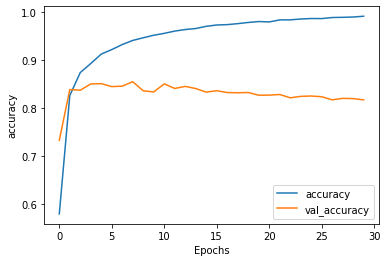

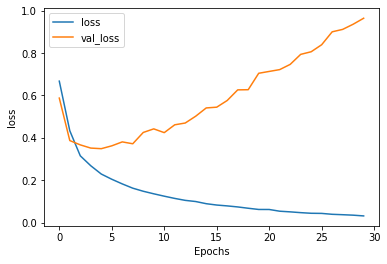

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 32)


In [16]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [19]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
results = model.predict(padded)

In [21]:
thresholding_value = 0.5

for idx, res in enumerate(results):
  if np.squeeze(res) > thresholding_value:
    print(sentence[idx], " : ", "Sarcasm")
  else:
    print(sentence[idx], " : ", "Not Sarcasm")

granny starting to fear spiders in the garden might be real  :  Sarcasm
game of thrones season finale showing this sunday night  :  Not Sarcasm
